In [1]:
import tensorflow as tf
import os




In [ ]:
def redimensionar_imagenes(ruta_directorio, nuevo_tamaño=(512, 512)):
    for subdir, dirs, files in os.walk(ruta_directorio):
        for file in files:
            ruta_completa = os.path.join(subdir, file)
            imagen = tf.io.read_file(ruta_completa)
            imagen = tf.image.decode_jpeg(imagen, channels=3)
            imagen_redimensionada = tf.image.resize(imagen, nuevo_tamaño)
            tf.io.write_file(ruta_completa, tf.image.encode_jpeg(tf.cast(imagen_redimensionada, tf.uint8)))

ruta_directorio = r"C:/Users/Matias/OneDrive/Escritorio/Tesis/dataset_consolidado"
redimensionar_imagenes(ruta_directorio)

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def limpiar_directorio(directorio):
    for filename in os.listdir(directorio):
        file_path = os.path.join(directorio, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

sample_size_percentage = 1

origen = r"C:/Users/Matias/OneDrive/Escritorio/Tesis/dataset_consolidado"
destino = r"C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset"

limpiar_directorio(destino)

categorias = ['benigno', 'maligno']
for cat in categorias:
    os.makedirs(os.path.join(destino, 'train', cat), exist_ok=True)
    os.makedirs(os.path.join(destino, 'val', cat), exist_ok=True)
    os.makedirs(os.path.join(destino, 'test', cat), exist_ok=True)
    
    archivos = os.listdir(os.path.join(origen, cat))
    np.random.shuffle(archivos)
    archivos = archivos[:int(len(archivos) * sample_size_percentage)]

    train_val, test = train_test_split(archivos, test_size=0.2, random_state=42)
    train, val = train_test_split(train_val, test_size=0.25, random_state=42)
    
    for archivo in train:
        shutil.copy(os.path.join(origen, cat, archivo), os.path.join(destino, 'train', cat, archivo))
    for archivo in val:
        shutil.copy(os.path.join(origen, cat, archivo), os.path.join(destino, 'val', cat, archivo))
    for archivo in test:
        shutil.copy(os.path.join(origen, cat, archivo), os.path.join(destino, 'test', cat, archivo))

target_size = (256, 256)  # Nuevo tamaño de las imágenes

train_dir = os.path.join(destino, 'train')
val_dir = os.path.join(destino, 'val')
test_dir = os.path.join(destino, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=20, 
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=20,  
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=20,  
    class_mode='binary')



Found 27144 images belonging to 2 classes.
Found 9048 images belonging to 2 classes.
Found 9048 images belonging to 2 classes.


# Modelo General

In [ ]:

model_simple = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'), 
    Dense(1, activation='sigmoid')
])

model_simple.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

history_simple = model_simple.fit(
    train_generator,
    steps_per_epoch=50,  
    epochs=10,
    validation_data=validation_generator,
    validation_steps=25  
)

acc = history_simple.history['accuracy']
val_acc = history_simple.history['val_accuracy']
loss = history_simple.history['loss']
val_loss = history_simple.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.layers import Dropout

model_complejo = Sequential([
    Conv2D(32, (3, 3), activation='relu',input_shape=(target_size[0], target_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_complejo.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])


history_complejo = model_complejo.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)

import matplotlib.pyplot as plt

acc = history_complejo.history['accuracy']
val_acc = history_complejo.history['val_accuracy']
loss = history_complejo.history['loss']
val_loss = history_complejo.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_preentrenado = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_preentrenado.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])


history_preentrenado = model_preentrenado.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)

import matplotlib.pyplot as plt

acc = history_preentrenado.history['accuracy']
val_acc = history_preentrenado.history['val_accuracy']
loss = history_preentrenado.history['loss']
val_loss = history_preentrenado.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


# Modelos diferenciados

In [2]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import pickle


def crear_dataframe(dataset_dir):
    subcarpetas = ['train', 'val', 'test']
    data = {'ruta': [], 'etiqueta': [], 'tipo': []}
    
    for subcarpeta in subcarpetas:
        for categoria in ['benigno', 'maligno']:
            dir_path = os.path.join(dataset_dir, subcarpeta, categoria)
            
            for filename in os.listdir(dir_path):
                parts = filename.split('_')
                
                # Verificar si el archivo es del tipo nuevo o del antiguo
                if len(parts) > 2 and (parts[0] == 'oral'):
                    # Formato nuevo: oral_benigno_Normal_400x_112_1_13
                    tipo_cancer = parts[0]  # 'oral'
                    etiqueta = parts[1]  # 'benigno' o 'maligno'
                    # No necesitamos concatenar el resto ya que solo queremos el tipo de cáncer y la etiqueta
                elif len(parts) == 3:
                    # Formato antiguo: colon_benigno_colonn3
                    tipo_cancer, etiqueta, _ = parts
                else:
                    print(f"Archivo {filename} ignorado por tener un formato incorrecto.")
                    continue  # Si no cumple con ninguno de los formatos esperados, ignorar este archivo
                
                ruta_completa = os.path.join(dir_path, filename)
                data['ruta'].append(ruta_completa)
                data['etiqueta'].append(etiqueta) 
                data['tipo'].append(tipo_cancer)
    
    return pd.DataFrame(data)

def crear_generadores_por_tipo(df, tipo_cancer, target_size=(256, 256), batch_size=20):
    # Filtrar el DataFrame por el tipo de cáncer
    df_filtrado = df[df['tipo'] == tipo_cancer]
    
    # Crear el ImageDataGenerator para reescalado
    datagen = ImageDataGenerator(rescale=1./255)
    
    # Filtrar adicionalmente por datos de entrenamiento y validación
    df_train = df_filtrado[df_filtrado['ruta'].str.contains('train')]
    df_val = df_filtrado[df_filtrado['ruta'].str.contains('val')]
    
    # Crear el generador de entrenamiento
    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col='ruta',
        y_col='etiqueta',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # Asumiendo clasificación binaria
        shuffle=True  # Importante para el entrenamiento
    )
    
    # Crear el generador de validación
    validation_generator = datagen.flow_from_dataframe(
        dataframe=df_val,
        x_col='ruta',
        y_col='etiqueta',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # Asumiendo clasificación binaria
        shuffle=False  # No es necesario mezclar para validación
    )
    
    return train_generator, validation_generator


def crear_generador_test(df, tipo_cancer, target_size=(256, 256), batch_size=20):
    # Filtrar el DataFrame por el tipo de cáncer y que la ruta contenga 'test'
    df_test = df[(df['tipo'] == tipo_cancer) & (df['ruta'].str.contains('test'))]
    
    datagen = ImageDataGenerator(rescale=1./255)  # Reescalado de las imágenes
    
    # Crear el generador de test
    test_generator = datagen.flow_from_dataframe(
        dataframe=df_test,
        x_col='ruta',
        y_col='etiqueta',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # Asumiendo clasificación binaria
        shuffle=False  # No se mezcla para asegurar la correspondencia con las etiquetas
    )
    
    return test_generator






In [ ]:
## Modelo Simple

In [3]:
def entrenar_modelo_simple(train_gen, val_gen, tipo_cancer):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_gen, steps_per_epoch = 100, epochs=10, validation_data=val_gen)

    # Guardar el modelo
    model.save(f'{tipo_cancer}_modelo_simple.h5')
    
    # Guardar el historial de entrenamiento
    with open(f'{tipo_cancer}_historial_simple.pickle', 'wb') as f:
        pickle.dump(history.history, f)
    
    return model, history


## Oscultacion Redes

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img


# Función para ocultar secciones de la imagen
def ocultar_seccion(imagen, top_left, tamano, valor_ocultacion=0.5):
    imagen_modificada = np.copy(imagen)
    x, y = top_left
    ancho, alto = tamano
    imagen_modificada[y:y+alto, x:x+ancho, :] = valor_ocultacion
    return imagen_modificada

# Función para visualizar la ocultación con predicción
def visualizar_ocultacion_con_prediccion(imagen, modelo, top_left, tamano_parche):
    imagen_oculta = ocultar_seccion(imagen, top_left, tamano_parche)
    prediccion = modelo.predict(np.expand_dims(imagen_oculta, axis=0))
    
    plt.figure(figsize=(6, 6))
    plt.imshow(imagen_oculta)
    plt.title(f"Predicción: {prediccion[0]}")
    plt.show()

    return prediccion


# Función para generar y mostrar el mapa de calor para una imagen
def generar_mostrar_mapa_calor(ruta_imagen, modelo, tamano_parche=32, paso=16):
    imagen = load_img(ruta_imagen, target_size=(256, 256))
    imagen_array = img_to_array(imagen) / 255.0
    mapa_calor = np.zeros((imagen_array.shape[0], imagen_array.shape[1]))

    # Predicción de la imagen original para comparar
    prediccion_original = modelo.predict(np.expand_dims(imagen_array, axis=0))[0][0]

    # Iterar sobre la imagen con un parche deslizante
    for y in range(0, imagen_array.shape[0] - tamano_parche, paso):
        for x in range(0, imagen_array.shape[1] - tamano_parche, paso):
            imagen_modificada = ocultar_seccion(imagen_array, (x, y), (tamano_parche, tamano_parche))
            prediccion_modificada = modelo.predict(np.expand_dims(imagen_modificada, axis=0))[0][0]
            cambio_prediccion = np.abs(prediccion_original - prediccion_modificada)
            mapa_calor[y:y+tamano_parche, x:x+tamano_parche] += cambio_prediccion

    # Normalizar el mapa de calor
    mapa_calor = mapa_calor / np.max(mapa_calor)

    # Visualizar el mapa de calor
    plt.figure(figsize=(10, 10))
    plt.imshow(imagen)
    plt.imshow(mapa_calor, cmap='jet', alpha=0.5)
    plt.title('Mapa de calor de la ocultación')
    plt.axis('off')
    plt.show()




## Modelo complejo

In [ ]:
from tensorflow.keras.layers import Dropout
def entrenar_modelo_complejo(train_gen, val_gen, tipo_cancer):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

    history = model.fit(train_gen,
                        steps_per_epoch=100,
                        epochs=10,
                        validation_data=val_gen)

    # Guardar el modelo
    model.save(f'{tipo_cancer}_modelo_complejo.h5')
    
    # Guardar el historial de entrenamiento
    with open(f'{tipo_cancer}_historial_complejo.pickle', 'wb') as f:
        pickle.dump(history.history, f)
    
    return model, history

## Modelo preentrenado

## ResNet50

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def entrenar_modelo_ResNet50(train_gen, val_gen, tipo_cancer):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

    history = model.fit(train_gen,
                        epochs=10,
                        steps_per_epoch=100,
                        validation_data=val_gen)

    # Guardar el modelo
    model.save(f'C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/{tipo_cancer}_models/{tipo_cancer}_modelo_ResNet50.h5')
    
    # Guardar el historial de entrenamiento
    with open(f'C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/{tipo_cancer}_models/{tipo_cancer}_historial_ResNet50.pickle', 'wb') as f:
        pickle.dump(history.history, f)
    
    return model, history


## VGG16

In [6]:
from keras.applications.vgg16 import VGG16

def entrenar_modelo_VGG16(train_gen, val_gen, tipo_cancer):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

    history = model.fit(train_gen,
                        epochs=10,
                        steps_per_epoch=100,
                        validation_data=val_gen)

    # Guardar el modelo
    model.save(f'C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/{tipo_cancer}_models/{tipo_cancer}_modelo_VGG16.h5')
    
    # Guardar el historial de entrenamiento
    with open(f'C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/{tipo_cancer}_models/{tipo_cancer}_historial_VGG16.pickle', 'wb') as f:
        pickle.dump(history.history, f)
    
    return model, history


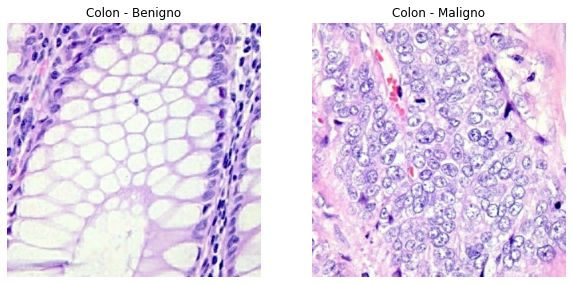

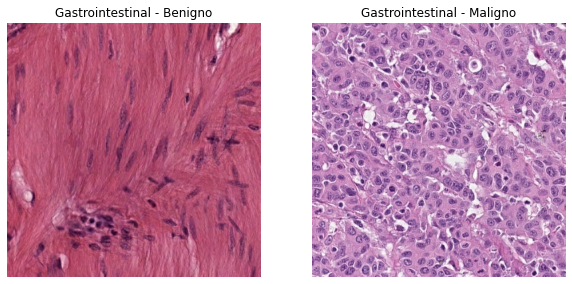

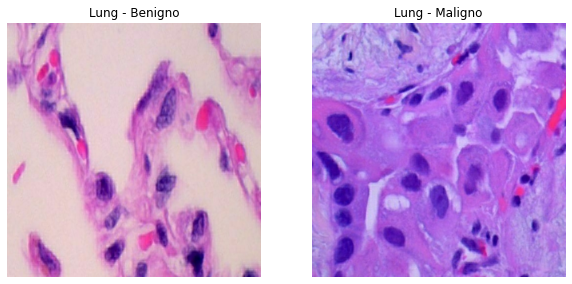

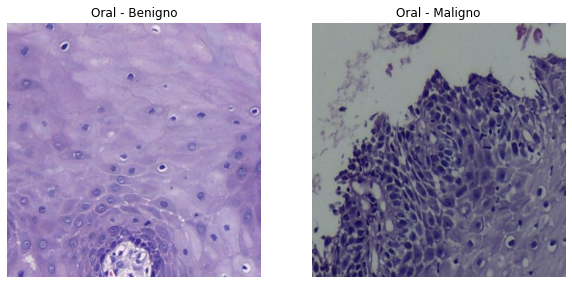

In [7]:
import matplotlib.image as mpimg

dataset_dir = r"C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset"
df = crear_dataframe(dataset_dir)

# Encuentra los tipos únicos de cáncer en el DataFrame
tipos_cancer = df['tipo'].unique()

from PIL import Image
import matplotlib.pyplot as plt

def mostrar_ejemplos_por_tipo(df):
    tipos_cancer = df['tipo'].unique()

    
    for tipo in tipos_cancer:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        for i, etiqueta in enumerate(['benigno', 'maligno']):
            # Filtra el DataFrame para obtener un ejemplo de cada tipo y etiqueta
            ejemplo = df[(df['tipo'] == tipo) & (df['etiqueta'] == etiqueta)].iloc[0]
            ruta_imagen = ejemplo['ruta']
            
            # Carga la imagen con Pillow
            img = Image.open(ruta_imagen)
            
            # Muestra la imagen
            axes[i].imshow(img)
            axes[i].set_title(f"{tipo.capitalize()} - {etiqueta.capitalize()}")
            axes[i].axis('off')
        
        plt.show()

# Suponiendo que tienes el DataFrame 'df' listo
# df = crear_dataframe('ruta_a_tu_dataset')
mostrar_ejemplos_por_tipo(df)




# Modelos Colon

## Modelos propios

In [ ]:

print(f"Entrenando y guardando modelos para {'colon'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'colon')
    
# Modelo Simple
modelo_simple, historia_simple = entrenar_modelo_simple(train_gen, val_gen, 'colon')


# Cargar el modelo
modelo_colon_simple = load_model('colon_modelo_simple.h5')

# Lista de imágenes para analizar
lista_rutas_imagenes = [
    r"C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca2.jpeg",
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca58.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca355.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca603.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca731.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca839.jpeg'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_colon_simple)


test_generator = crear_generador_test(df, 'colon', target_size=(256, 256), batch_size=20)

resultado_test = modelo_colon_simple.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)


In [ ]:



print(f"Entrenando y guardando modelos para {'colon'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'colon')
    
# Modelo complejo
modelo_complejo, historia_complejo = entrenar_modelo_complejo(train_gen, val_gen, 'colon')

# Cargar el modelo
modelo_colon_complejo = load_model('colon_modelo_complejo.h5')


'''# Lista de imágenes para analizar
lista_rutas_imagenes = [
    r"C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca2.jpeg",
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca58.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca355.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca603.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca731.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca839.jpeg'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_colon_complejo)'''


test_generator = crear_generador_test(df, 'colon', target_size=(256, 256), batch_size=20)

resultado_test = modelo_colon_complejo.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)


## Entrenamiento ResNet50

In [8]:
print(f"Entrenando y guardando modelos para {'lung'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'colon')
    
# Modelo ResNet50 preentrenado
modelo_preentrenado, historia_preentrenado = entrenar_modelo_ResNet50(train_gen, val_gen, 'colon')

# Cargar el modelo
modelo_colon_preentrenado = load_model('C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/colon_models/colon_modelo_ResNet50.h5')

'''# Lista de imágenes para analizar
lista_rutas_imagenes = [
    r"C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca2.jpeg",
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca58.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca355.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca603.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca731.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca839.jpeg'
    ]'''
'''
# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_colon_preentrenado)'''

test_generator = crear_generador_test(df, 'colon', target_size=(256, 256), batch_size=20)
resultado_test = modelo_colon_preentrenado.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)

Entrenando y guardando modelos para lung...
Found 10000 validated image filenames belonging to 2 classes.
Found 1970 validated image filenames belonging to 2 classes.
Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - FalseNegatives: 181.3564 - FalsePositives: 186.3564 - accuracy: 0.6020 - loss: 0.7705 - val_FalseNegatives: 152.0000 - val_FalsePositives: 271.0000 - val_accuracy: 0.7853 - val_loss: 0.4912
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - FalseNegatives: 118.8218 - FalsePositives: 116.5149 - accuracy: 0.7714 - loss: 0.4942 - val_FalseNegatives: 93.0000 - val_FalsePositives: 334.0000 - val_accuracy: 0.7832 - val_loss: 0.4830
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - FalseNegatives: 99.8119 - FalsePositives: 107.5247 - accuracy: 0.8015 - loss: 0.4670 - val_FalseNegatives: 137.0000 - val_FalsePositives: 250.0000 - val_accuracy: 0.8036 - val_loss: 0.4425
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - FalseNegatives: 107.5247 - FalsePositives: 105.4158 - accuracy: 0.8034 - loss: 0.4502 - val_FalseNegatives: 263.0000 - val_FalsePositives: 123.0000 - val_accuracy: 0.8041 - val_loss: 0.4494
Epoch 5/10
100/100 ━━━━━━━━━━━━━━

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 998ms/step - FalseNegatives: 0.0000e+00 - FalsePositives: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_FalseNegatives: 64.0000 - val_FalsePositives: 411.0000 - val_accuracy: 0.7589 - val_loss: 0.5201
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - FalseNegatives: 104.4356 - FalsePositives: 115.9109 - accuracy: 0.7847 - loss: 0.4641 - val_FalseNegatives: 97.0000 - val_FalsePositives: 281.0000 - val_accuracy: 0.8081 - val_loss: 0.4369
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - FalseNegatives: 90.9901 - FalsePositives: 101.4158 - accuracy: 0.8102 - loss: 0.4552 - val_FalseNegatives: 115.0000 - val_FalsePositives: 247.0000 - val_accuracy: 0.8162 - val_loss: 0.4199
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - FalseNegatives: 95.7030 - FalsePositives: 109.8812 - accuracy: 0.8003 - loss: 0.4579 - val_FalseNegatives: 211.0000 - val_FalsePositives: 138.0000 - val_accuracy: 0.8228 - val_loss: 0.4145
Epoch 10/10
100/100 

Found 2022 validated image filenames belonging to 2 classes.


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8092 - false_negatives_1: 35.5049 - false_positives_1: 160.4951 - loss: 0.4168
Resultado de la evaluación en el conjunto de test: [0.39544594287872314, 0.8288822770118713, 130.0, 216.0]


## Entrenamiento VGG16

In [9]:
print(f"Entrenando y guardando modelos para {'lung'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'colon')
    
# Modelo ResNet50 preentrenado
modelo_preentrenado, historia_preentrenado = entrenar_modelo_VGG16(train_gen, val_gen, 'colon')

# Cargar el modelo
modelo_colon_preentrenado = load_model('C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/colon_models/colon_modelo_VGG16.h5')

'''# Lista de imágenes para analizar
lista_rutas_imagenes = [
    r"C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca2.jpeg",
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca58.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca355.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca603.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca731.jpeg',
    r'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/colon_maligno_colonca839.jpeg'
    ]'''
'''
# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_colon_preentrenado)'''

resultado_test = modelo_colon_preentrenado.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)

Entrenando y guardando modelos para lung...
Found 10000 validated image filenames belonging to 2 classes.
Found 1970 validated image filenames belonging to 2 classes.
Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - FalseNegatives: 62.3267 - FalsePositives: 60.7327 - accuracy: 0.8224 - loss: 0.3836 - val_FalseNegatives: 9.0000 - val_FalsePositives: 21.0000 - val_accuracy: 0.9848 - val_loss: 0.0811
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 410s 4s/step - FalseNegatives: 9.2871 - FalsePositives: 15.1287 - accuracy: 0.9772 - loss: 0.0870 - val_FalseNegatives: 4.0000 - val_FalsePositives: 17.0000 - val_accuracy: 0.9893 - val_loss: 0.0459
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - FalseNegatives: 3.9703 - FalsePositives: 10.1287 - accuracy: 0.9882 - loss: 0.0446 - val_FalseNegatives: 2.0000 - val_FalsePositives: 22.0000 - val_accuracy: 0.9878 - val_loss: 0.0375
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - FalseNegatives: 1.6931 - FalsePositives: 5.5248 - accuracy: 0.9940 - loss: 0.0253 - val_FalseNegatives: 3.0000 - val_FalsePositives: 10.0000 - val_accuracy: 0.9934 - val_loss: 0.0283
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - 

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - FalseNegatives: 0.0000e+00 - FalsePositives: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_FalseNegatives: 1.0000 - val_FalsePositives: 24.0000 - val_accuracy: 0.9873 - val_loss: 0.0401
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - FalseNegatives: 1.2772 - FalsePositives: 4.5446 - accuracy: 0.9951 - loss: 0.0193 - val_FalseNegatives: 2.0000 - val_FalsePositives: 10.0000 - val_accuracy: 0.9939 - val_loss: 0.0203
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - FalseNegatives: 1.7723 - FalsePositives: 3.9703 - accuracy: 0.9948 - loss: 0.0193 - val_FalseNegatives: 3.0000 - val_FalsePositives: 7.0000 - val_accuracy: 0.9949 - val_loss: 0.0179
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - FalseNegatives: 2.1188 - FalsePositives: 3.3465 - accuracy: 0.9952 - loss: 0.0171 - val_FalseNegatives: 3.0000 - val_FalsePositives: 7.0000 - val_accuracy: 0.9949 - val_loss: 0.0159
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 404s

102/102 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9825 - false_negatives_3: 0.0000e+00 - false_positives_3: 17.4175 - loss: 0.0388
Resultado de la evaluación en el conjunto de test: [0.027983877807855606, 0.9881305694580078, 0.0, 24.0]


# Modelos Lung

## Modelos propios

In [ ]:
print(f"Entrenando y guardando modelos para {'lung'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'lung')
        
# Modelo preentrenado
modelo_simple, historia_simple = entrenar_modelo_simple(train_gen, val_gen, 'lung')

# Cargar el modelo
modelo_lung_simple = load_model('lung_modelo_simple.h5')

# Lista de imágenes para analizar
lista_rutas_imagenes = [
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca72.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1661.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1887.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1927.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca2442.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca2730.jpeg'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_lung_simple)


test_generator = crear_generador_test(df, 'lung', target_size=(256, 256), batch_size=20)

resultado_test = modelo_lung_simple.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)


In [ ]:
print(f"Entrenando y guardando modelos para {'lung'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'lung')
    
# Modelo complejo
modelo_complejo, historia_complejo = entrenar_modelo_complejo(train_gen, val_gen, 'lung')

# Cargar el modelo
modelo_lung_complejo = load_model('lung_modelo_complejo.h5')

# Lista de imágenes para analizar
lista_rutas_imagenes = [
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca72.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1661.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1887.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1927.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca2442.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca2730.jpeg'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_lung_complejo)


test_generator = crear_generador_test(df, 'lung', target_size=(256, 256), batch_size=20)

resultado_test = modelo_lung_complejo.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)

## ResNet50

In [10]:
print(f"Entrenando y guardando modelos para {'lung'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'lung')
        
# Modelo preentrenado
modelo_preentrenado, historia_preentrenado = entrenar_modelo_ResNet50(train_gen, val_gen, 'lung')



# Cargar el modelo
modelo_lung_preentrenado = load_model('C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/lung_models/lung_modelo_ResNet50.h5')

'''# Lista de imágenes para analizar
lista_rutas_imagenes = [
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca72.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1661.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1887.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1927.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca2442.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca2730.jpeg'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_lung_preentrenado)'''


test_generator = crear_generador_test(df, 'lung', target_size=(256, 256), batch_size=20)

resultado_test = modelo_lung_preentrenado.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test) 




Entrenando y guardando modelos para lung...
Found 15000 validated image filenames belonging to 2 classes.
Found 2983 validated image filenames belonging to 2 classes.
Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - FalseNegatives: 114.4356 - FalsePositives: 242.6832 - accuracy: 0.6503 - loss: 0.7230 - val_FalseNegatives: 372.0000 - val_FalsePositives: 431.0000 - val_accuracy: 0.7308 - val_loss: 0.5969
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - FalseNegatives: 96.5050 - FalsePositives: 241.1386 - accuracy: 0.6549 - loss: 0.6240 - val_FalseNegatives: 1.0000 - val_FalsePositives: 989.0000 - val_accuracy: 0.6681 - val_loss: 0.5779
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - FalseNegatives: 91.3366 - FalsePositives: 218.1881 - accuracy: 0.6931 - loss: 0.5783 - val_FalseNegatives: 206.0000 - val_FalsePositives: 405.0000 - val_accuracy: 0.7952 - val_loss: 0.5034
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - FalseNegatives: 67.5149 - FalsePositives: 201.8020 - accuracy: 0.7360 - loss: 0.5350 - val_FalseNegatives: 6.0000 - val_FalsePositives: 840.0000 - val_accuracy: 0.7164 - val_loss: 0.4715
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - FalseNegatives: 62.7500 - FalsePositives: 99.6500 - accuracy: 0.7705 - loss: 0.4633 - val_FalseNegatives: 112.0000 - val_FalsePositives: 169.0000 - val_accuracy: 0.9058 - val_loss: 0.3174
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - FalseNegatives: 30.0792 - FalsePositives: 86.6931 - accuracy: 0.8892 - loss: 0.3073 - val_FalseNegatives: 519.0000 - val_FalsePositives: 7.0000 - val_accuracy: 0.8237 - val_loss: 0.4184
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - FalseNegatives: 67.2277 - FalsePositives: 101.9307 - accuracy: 0.8225 - loss: 0.3838 - val_FalseNegatives: 14.0000 - val_FalsePositives: 452.0000 - val_accuracy: 0.8438 - val_loss: 0.3030


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/lung_models/lung_modelo_preentrenado.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## VGG16

In [12]:
print(f"Entrenando y guardando modelos para {'lung'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'lung')
        
# Modelo preentrenado
modelo_preentrenado, historia_preentrenado = entrenar_modelo_VGG16(train_gen, val_gen, 'lung')

# Cargar el modelo
modelo_lung_preentrenado = load_model('C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/lung_models/lung_modelo_VGG16.h5')

'''# Lista de imágenes para analizar
lista_rutas_imagenes = [
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca72.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1661.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1887.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca1927.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca2442.jpeg',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/lung_maligno_lungaca2730.jpeg'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_lung_preentrenado)'''


resultado_test = modelo_lung_preentrenado.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)


Entrenando y guardando modelos para lung...
Found 15000 validated image filenames belonging to 2 classes.
Found 2983 validated image filenames belonging to 2 classes.
Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 495s 5s/step - FalseNegatives: 22.6139 - FalsePositives: 34.3564 - accuracy: 0.9037 - loss: 0.2172 - val_FalseNegatives: 24.0000 - val_FalsePositives: 1.0000 - val_accuracy: 0.9916 - val_loss: 0.0378
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - FalseNegatives: 5.9802 - FalsePositives: 2.5941 - accuracy: 0.9915 - loss: 0.0351 - val_FalseNegatives: 12.0000 - val_FalsePositives: 7.0000 - val_accuracy: 0.9936 - val_loss: 0.0258
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 487s 5s/step - FalseNegatives: 8.5545 - FalsePositives: 4.4257 - accuracy: 0.9860 - loss: 0.0325 - val_FalseNegatives: 18.0000 - val_FalsePositives: 0.0000e+00 - val_accuracy: 0.9940 - val_loss: 0.0200
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 806s 8s/step - FalseNegatives: 3.9307 - FalsePositives: 2.7327 - accuracy: 0.9935 - loss: 0.0176 - val_FalseNegatives: 19.0000 - val_FalsePositives: 0.0000e+00 - val_accuracy: 0.9936 - val_loss: 0.0189
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 718s 7s/s

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - FalseNegatives: 3.2600 - FalsePositives: 2.2200 - accuracy: 0.9931 - loss: 0.0212 - val_FalseNegatives: 11.0000 - val_FalsePositives: 0.0000e+00 - val_accuracy: 0.9963 - val_loss: 0.0105
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 502s 5s/step - FalseNegatives: 1.4950 - FalsePositives: 0.2574 - accuracy: 0.9989 - loss: 0.0072 - val_FalseNegatives: 1.0000 - val_FalsePositives: 4.0000 - val_accuracy: 0.9983 - val_loss: 0.0080
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 504s 5s/step - FalseNegatives: 1.8218 - FalsePositives: 0.1584 - accuracy: 0.9975 - loss: 0.0079 - val_FalseNegatives: 5.0000 - val_FalsePositives: 1.0000 - val_accuracy: 0.9980 - val_loss: 0.0054


154/154 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9976 - false_negatives_7: 1.3935 - false_positives_7: 1.7226 - loss: 0.0085
Resultado de la evaluación en el conjunto de test: [0.005735162179917097, 0.9983692169189453, 3.0, 2.0]


# Modelos Gastrointestinal

## Modelos propios

In [ ]:
print(f"Entrenando y guardando modelos para {'gastrointestinal'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'gastrointestinal')
    
# Modelo Simple
modelo_simple, historia_simple = entrenar_modelo_simple(train_gen, val_gen, 'gastrointestinal')
# Cargar el modelo
modelo_gastrointestinal_simple = load_model('gastrointestinal_modelo_simple.h5')

# Lista de imágenes para analizar
lista_rutas_imagenes = [
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_STU-VVAYSTFEDVCK.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_STU-YMQEGVFNVFSW.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-AWMKICNLSCML.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-DFAEHFGCIPME.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-ELCGGYACMKSG.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-IQEPIQTLMWQT.png'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_gastrointestinal_simple)


test_generator = crear_generador_test(df, 'gastrointestinal', target_size=(256, 256), batch_size=20)

resultado_test = modelo_gastrointestinal_simple.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)

In [ ]:
print(f"Entrenando y guardando modelos para {'gastrointestinal'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'gastrointestinal')
    
# Modelo complejo
modelo_complejo, historia_complejo = entrenar_modelo_complejo(train_gen, val_gen, 'gastrointestinal')
# Cargar el modelo
modelo_gastrointestinal_complejo = load_model('gastrointestinal_modelo_complejo.h5')

# Lista de imágenes para analizar
lista_rutas_imagenes = [
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_STU-VVAYSTFEDVCK.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_STU-YMQEGVFNVFSW.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-AWMKICNLSCML.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-DFAEHFGCIPME.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-ELCGGYACMKSG.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-IQEPIQTLMWQT.png'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_gastrointestinal_complejo)


test_generator = crear_generador_test(df, 'gastrointestinal', target_size=(256, 256), batch_size=20)

resultado_test = modelo_gastrointestinal_complejo.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)


## ResNet50

In [13]:
print(f"Entrenando y guardando modelos para {'gastrointestinal'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'gastrointestinal')
    
# Modelo ResNet50 preentrenado
modelo_preentrenado, historia_preentrenado = entrenar_modelo_ResNet50(train_gen, val_gen, 'gastrointestinal')
# Cargar el modelo
modelo_gastrointestinal_preentrenado= load_model('C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/gastrointestinal_models/gastrointestinal_modelo_ResNet50.h5')

# Lista de imágenes para analizar
lista_rutas_imagenes = [
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_STU-VVAYSTFEDVCK.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_STU-YMQEGVFNVFSW.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-AWMKICNLSCML.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-DFAEHFGCIPME.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-ELCGGYACMKSG.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-IQEPIQTLMWQT.png'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_gastrointestinal_preentrenado)


test_generator = crear_generador_test(df, 'gastrointestinal', target_size=(256, 256), batch_size=20)

resultado_test = modelo_gastrointestinal_preentrenado.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)

Entrenando y guardando modelos para gastrointestinal...
Found 8000 validated image filenames belonging to 2 classes.
Found 1585 validated image filenames belonging to 2 classes.
Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - FalseNegatives: 191.4455 - FalsePositives: 171.3069 - accuracy: 0.6086 - loss: 0.7839 - val_FalseNegatives: 527.0000 - val_FalsePositives: 48.0000 - val_accuracy: 0.6372 - val_loss: 0.6545
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - FalseNegatives: 152.1782 - FalsePositives: 143.0495 - accuracy: 0.7073 - loss: 0.5628 - val_FalseNegatives: 157.0000 - val_FalsePositives: 229.0000 - val_accuracy: 0.7565 - val_loss: 0.5159
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - FalseNegatives: 125.4653 - FalsePositives: 135.9901 - accuracy: 0.7511 - loss: 0.5193 - val_FalseNegatives: 369.0000 - val_FalsePositives: 69.0000 - val_accuracy: 0.7237 - val_loss: 0.5783
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - FalseNegatives: 121.7723 - FalsePositives: 142.9010 - accuracy: 0.7435 - loss: 0.5226 - val_FalseNegatives: 280.0000 - val_FalsePositives: 113.0000 - val_accuracy: 0.7521 - val_loss: 0.5251
Epoch 5/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 836ms/step - FalseNegatives: 0.0000e+00 - FalsePositives: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_FalseNegatives: 280.0000 - val_FalsePositives: 113.0000 - val_accuracy: 0.7521 - val_loss: 0.5251
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - FalseNegatives: 134.8416 - FalsePositives: 146.9208 - accuracy: 0.7349 - loss: 0.5465 - val_FalseNegatives: 127.0000 - val_FalsePositives: 255.0000 - val_accuracy: 0.7590 - val_loss: 0.5153
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - FalseNegatives: 132.2574 - FalsePositives: 138.4356 - accuracy: 0.7231 - loss: 0.5497 - val_FalseNegatives: 65.0000 - val_FalsePositives: 403.0000 - val_accuracy: 0.7047 - val_loss: 0.5564
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - FalseNegatives: 118.5644 - FalsePositives: 143.0000 - accuracy: 0.7361 - loss: 0.5392 - val_FalseNegatives: 180.0000 - val_FalsePositives: 176.0000 - val_accuracy: 0.7754 - val_loss: 0.4887
Epoch 9/10
100/100

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_STU-VVAYSTFEDVCK.png'

## VGG16

In [ ]:
print(f"Entrenando y guardando modelos para {'gastrointestinal'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'gastrointestinal')
    
# Modelo ResNet50 preentrenado
modelo_preentrenado, historia_preentrenado = entrenar_modelo_VGG16(train_gen, val_gen, 'gastrointestinal')
# Cargar el modelo
modelo_gastrointestinal_preentrenado= load_model('C:/Users/Matias/OneDrive/Escritorio/Tesis/Tesis-Models/gastrointestinal_models/gastrointestinal_modelo_VGG16.h5')

'''# Lista de imágenes para analizar
lista_rutas_imagenes = [
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_STU-VVAYSTFEDVCK.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_STU-YMQEGVFNVFSW.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-AWMKICNLSCML.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-DFAEHFGCIPME.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-ELCGGYACMKSG.png',
    'C:/Users/Matias/OneDrive/Escritorio/Tesis/train_dataset/test/maligno/gastrointestinal_maligno_TUM-IQEPIQTLMWQT.png'
    ]

# Generar y mostrar mapas de calor para cada imagen
for ruta_imagen in lista_rutas_imagenes:
    generar_mostrar_mapa_calor(ruta_imagen, modelo_gastrointestinal_preentrenado)'''




resultado_test = modelo_gastrointestinal_preentrenado.evaluate(test_generator)
print("Resultado de la evaluación en el conjunto de test:", resultado_test)

In [ ]:
import matplotlib.pyplot as plt

def visualizar_historial(historia):
    acc = historia['accuracy']
    val_acc = historia['val_accuracy']
    loss = historia['loss']
    val_loss = historia['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', label='Precisión de entrenamiento')
    plt.plot(epochs, val_acc, 'b', label='Precisión de validación')
    plt.title('Precisión de Entrenamiento y Validación')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
    plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.legend()

    plt.show()


In [ ]:
def cargar_historial(tipo_cancer, tipo_modelo):
    with open(f'{tipo_cancer}_historial_{tipo_modelo}.pickle', 'rb') as f:
        history = pickle.load(f)
    return history




In [ ]:
historia = cargar_historial('colon', 'simple')
visualizar_historial(historia)

In [ ]:
historia = cargar_historial('colon', 'complejo')
visualizar_historial(historia)


In [ ]:
historia = cargar_historial('colon', 'preentrenado')
visualizar_historial(historia)

In [ ]:
historia = cargar_historial('lung', 'simple')
visualizar_historial(historia)

In [ ]:
historia = cargar_historial('lung', 'complejo')
visualizar_historial(historia)


In [ ]:
historia = cargar_historial('lung', 'preentrenado')
visualizar_historial(historia)

In [ ]:
historia = cargar_historial('gastrointestinal', 'simple')
visualizar_historial(historia)

In [ ]:
historia = cargar_historial('gastrointestinal', 'complejo')
visualizar_historial(historia)

In [ ]:
historia = cargar_historial('gastrointestinal', 'preentrenado')
visualizar_historial(historia)